In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import kts

In [3]:
from kts.validation.validator import *
from kts.validation.split import *
from kts.zoo.binary_classification import *
from kts.feature import stl
from kts.feature.decorators import *
from kts.optimization.optimizer import *
from kts.feature.storage import feature_list as features
from kts.feature.storage import FeatureSet
from kts.validation.experiment import experiment_list as experiments
from kts.storage.cache_utils import clear_storage

from sklearn.metrics import roc_auc_score

# Reading datasets

In [4]:
path_test = '../input/test.csv'
path_train = '../input/train.csv'

In [5]:
train = pd.read_csv(path_train)
train = train.set_index('PassengerId')
test = pd.read_csv(path_test)
test = test.set_index('PassengerId')

In [6]:
train.shape, test.shape

((891, 11), (418, 10))

In [7]:
target = train.Survived.values

# Feature engineering

In [8]:
# List of registered functions
features

[]

In [9]:
# List of experiments
experiments

Experiments: [

]

In [10]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
train.head(7)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [12]:
numeric_features = ['Age', 'Fare']
ordered_cat_features = ['Pclass', 'Parch', 'SibSp']
unordered_cat_features = ['Embarked']
text_features = ['Name', 'Ticket', 'Cabin']
binary_features = ['Sex']

In [13]:
# When you have a hypothesis that some new features 
# may be useful define a function to constuct a feature

# You can preview how your functions behaves before registering it

@preview(train)
def label_embarked(df):
    res = stl.empty_like(df)
    res['Embarked_label'] = df.Embarked.map({'S': 1, 'C': 2, 'Q': 3})
    return res[['Embarked_label']]

,Embarked_label
PassengerId,
1,1
2,2


,Embarked_label
PassengerId,
1,1
2,2
3,1
4,1


,Embarked_label
PassengerId,
1,1
2,2
3,1
4,1
5,1
6,3


In [14]:
# Register some functions that extract new features from the training data
# Registered functions calls are cached so you don't have to redo calculations many times

@register
def binarize_sex(df):
    res = stl.empty_like(df)
    res['Sex_binary'] = df.Sex.map({'male': 1, 'female': 0})
    return res[['Sex_binary']]

@register
def drop_text_features(df):
    return stl.column_dropper(text_features)(df)

@register
def label_embarked(df):
    res = stl.empty_like(df)
    res['Embarked_label'] = df.Embarked.map({'S': 1, 'C': 2, 'Q': 3})
    return res[['Embarked_label']]

@register
def ohe_embarked(df):
    return stl.make_ohe(['Embarked'])(df)

@register
def mean_enc_embarked(df):
    return stl.make_mean_encoding(['Embarked'], 'Survived')(df)

@register
def make_fs_without_text(df):
    return stl.concat([drop_text_features, label_embarked, binarize_sex])(df)

@dropper
def drop_sex_embarked(df):
    return stl.column_dropper(['Sex', 'Embarked'])(df)

@register
def log_fare(df):
    res = stl.empty_like(df)
    res['log_Fare'] = df.Fare.apply(lambda x: np.log(x+1))
    return res[['log_Fare']]

@register
def age_isna(df):
    res = stl.empty_like(df)
    res['Age_isna'] = df.Age.isna().astype(int)
    return res[['Age_isna']]

@register
def age_fillna(df):
    res = stl.empty_like(df)
    res['Age_fillna'] = df.Age.fillna(df.Age.mean())
    return res[['Age_fillna']]

@register
def Cabin_isna(df):
    res = stl.empty_like(df)
    res['Cabin_isna'] = df.Cabin.isna().astype(int)
    return res[['Cabin_isna']]

@register
def cabin_first_letter(df):
    res = stl.empty_like(df)
    res['Cabin_first_letter'] = df.Cabin.fillna(-1).apply(lambda x: str(x)[0])
    return stl.make_ohe(['Cabin_first_letter'])(res)

@register
def fs_no_text_sex_embarked_altered(df):
    return drop_sex_embarked(make_fs_without_text(df))

In [15]:
# You can deregister a function
@register
def bad_function(df):
    pass

deregister('bad_function', force=True)

removing ../storage/bad_function_fc_obj
removing ../storage/sources/bad_function.py


In [16]:
# you can define all registered functions
# in other notebooks with just a one line 

features.define_in_scope(globals())

# Preparing feature sets for validation

In [17]:
# FeatureSet is constructed using one registered function and initial dataframe

@register
def constuct_fs_1(df):
    return stl.concat([stl.column_dropper(text_features + ['Sex', 'Embarked', 'Age']), 
                              ohe_embarked, 
                              age_isna, 
                              age_fillna])(df)
fs_1 = FeatureSet(constuct_fs_1, df_input=train, target_column='Survived')

@register
def construct_fs_2(df):
    return stl.concat([stl.column_dropper(text_features + ['Sex', 'Embarked', 'Age']), 
                              mean_enc_embarked, 
                              log_fare, 
                              age_fillna])(df)
fs_2 = FeatureSet(construct_fs_2, df_input=train, target_column='Survived')

@register
def construct_fs_3(df):
    return stl.concat([stl.column_dropper(text_features + ['Sex', 'Embarked', 'Age']), 
                              label_embarked, 
                              age_isna, 
                              age_fillna, 
                              cabin_first_letter])(df)
fs_3 = FeatureSet(construct_fs_3, df_input=train, target_column='Survived')

In [18]:
# FeatureSets are "smart dataframes". 
# They can be called to transform any other dataframe similar to that passed to df_input
# It is mostly used for preprocessing test data in a single string 

In [19]:
fs_1[:5]

,Survived,Pclass,SibSp,Parch,Fare,Embarked_ohe_C,Embarked_ohe_Q,Embarked_ohe_S,Age_isna,Age_fillna
PassengerId,,,,,,,,,,
1,0,3,1,0,7.2500,0,0,1,0,22.0
2,1,1,1,0,71.2833,1,0,0,0,38.0
3,1,3,0,0,7.9250,0,0,1,0,26.0
4,1,1,1,0,53.1000,0,0,1,0,35.0
5,0,3,0,0,8.0500,0,0,1,0,35.0


In [20]:
fs_2[:5]

,Survived,Pclass,SibSp,Parch,Fare,me_Embarked,log_Fare,Age_fillna
PassengerId,,,,,,,,
1,0,3,1,0,7.2500,0.336957,2.110213,22.0
2,1,1,1,0,71.2833,0.553571,4.280593,38.0
3,1,3,0,0,7.9250,0.336957,2.188856,26.0
4,1,1,1,0,53.1000,0.336957,3.990834,35.0
5,0,3,0,0,8.0500,0.336957,2.202765,35.0


In [21]:
fs_3[:5]

,Survived,Pclass,SibSp,Parch,Fare,Embarked_label,Age_isna,Age_fillna,Cabin_first_letter_ohe_-,Cabin_first_letter_ohe_A,Cabin_first_letter_ohe_B,Cabin_first_letter_ohe_C,Cabin_first_letter_ohe_D,Cabin_first_letter_ohe_E,Cabin_first_letter_ohe_F,Cabin_first_letter_ohe_G,Cabin_first_letter_ohe_T
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,1,0,7.2500,1.0,0,22.0,1,0,0,0,0,0,0,0,0
2,1,1,1,0,71.2833,2.0,0,38.0,0,0,0,1,0,0,0,0,0
3,1,3,0,0,7.9250,1.0,0,26.0,1,0,0,0,0,0,0,0,0
4,1,1,1,0,53.1000,1.0,0,35.0,0,0,0,1,0,0,0,0,0
5,0,3,0,0,8.0500,1.0,0,35.0,1,0,0,0,0,0,0,0,0


In [22]:
# Instant test data preprocessing
fs_1(test)

,Pclass,SibSp,Parch,Fare,Embarked_ohe_C,Embarked_ohe_Q,Embarked_ohe_S,Age_isna,Age_fillna
PassengerId,,,,,,,,,
892,3,0,0,7.8292,0,1,0,0,34.50000
893,3,1,0,7.0000,0,0,1,0,47.00000
894,2,0,0,9.6875,0,1,0,0,62.00000
895,3,0,0,8.6625,0,0,1,0,27.00000
896,3,1,1,12.2875,0,0,1,0,22.00000
897,3,0,0,9.2250,0,0,1,0,14.00000
898,3,0,0,7.6292,0,1,0,0,30.00000
899,2,1,1,29.0000,0,0,1,0,26.00000
900,3,0,0,7.2292,1,0,0,0,18.00000


In [23]:
type(fs_1[:]), type(fs_1(test))

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

# Preparing models

In [24]:
# Initialize some models from kts.zoo
# You can set any parameters for a model by passing a dictionary 
xgb = XGBClassifier() # default XGBoost
lgb = LGBMClassifier({'max_depth': 100, 
                      'num_leaves': 50, 
                      'n_estimators': 150, 
                      'boosting_type': 'gbdt'}) # custom LightGBM
cb = CBClassifier(verbosity=False) # default CatBoost

# Preparing validation

In [25]:
# Validation is easy with kts
# You just need a Splitter and a Validator

skf = SKF(target, n_folds=5, seed=42) # Stratified k-fold
nm = NM(target, SKF, n_folds=5, n_splits=4) # N * M fold cross-validation

val_skf = Validator(skf, roc_auc_score) # Validator needs a splitter and a metric
val_nm = Validator(nm, roc_auc_score)

In [26]:
# List of experiments
experiments

Experiments: [

]

In [27]:
# Calculate score for any model and FeatureSet
print(val_skf.score(lgb, fs_1))
print(val_skf.score(lgb, fs_2))
print(val_skf.score(lgb, fs_3))

Val of lgb_65:   0%|          | 0/5 [00:00<?, ?it/s]

0.7467692493104868


Val of lgb_65:   0%|          | 0/5 [00:00<?, ?it/s]

0.753177882677167


Val of lgb_65: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it, score: 0.7484491036505985]

0.7484491036505985


In [28]:
print(val_skf.score(xgb, fs_1))
print(val_skf.score(xgb, fs_2))
print(val_skf.score(xgb, fs_3))

Val of xgb_default:  20%|██        | 1/5 [00:00<00:00,  6.79it/s, score: 0.8171277997364954]

0.7619186278420422


Val of xgb_default:  20%|██        | 1/5 [00:00<00:00,  5.52it/s, score: 0.8274703557312253]

0.7612109640244391


Val of xgb_default: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s, score: 0.7701535522284484]

0.7701535522284484


In [29]:
print(val_skf.score(cb, fs_1))
print(val_skf.score(cb, fs_2))
print(val_skf.score(cb, fs_3))

Val of cb_default:   0%|          | 0/5 [00:00<?, ?it/s]

0.7542363592280297


Val of cb_default:   0%|          | 0/5 [00:00<?, ?it/s]

0.7548880780872381


Val of cb_default: 100%|██████████| 5/5 [00:33<00:00,  6.61s/it, score: 0.7542222081202936]

0.7542222081202936


In [30]:
# All experiments were saved in the list of experiments
experiments

Experiments: [
(0.77015, std:0.052: 
	Model: ens_xgb_default_x5)
(0.76192, std:0.05: 
	Model: ens_xgb_default_x5)
(0.76121, std:0.05: 
	Model: ens_xgb_default_x5)
(0.75489, std:0.033: 
	Model: ens_cb_default_x5)
(0.75424, std:0.036: 
	Model: ens_cb_default_x5)
(0.75318, std:0.037: 
	Model: ens_lgb_65_x5)
(0.74845, std:0.033: 
	Model: ens_lgb_65_x5)
(0.74677, std:0.039: 
	Model: ens_lgb_65_x5)
]

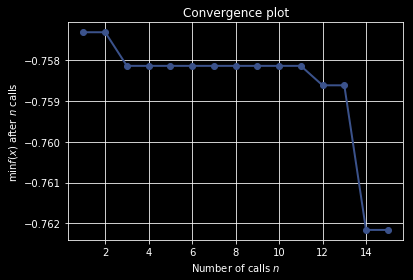

In [31]:
# You can optimize hyperparameters of 
# any model on a particular FeatureSet with Optimizer

# Optimizer works on scikit-optimize

spaces = {'max_depth': (10, 190), 
          'num_leaves': (20, 200), 
          'n_estimators': (100, 200), 
          'boosting_type': ('gbdt', 'dart')}
opt = Optimizer(lgb, fs_2, target, val_skf, goal='maximize', search_spaces=spaces)
opt.optimize(n_iters = 15)

In [32]:
# You can get any experiment from list of 
# experiments by index, score or model name 

experiments[0.76:0.78]

[0.77:exp(ens_xgb_default_x5),
 0.762:exp(ens_lgb_dc_x5),
 0.762:exp(ens_lgb_75_x5),
 0.762:exp(ens_xgb_default_x5),
 0.761:exp(ens_xgb_default_x5)]

In [33]:
experiments['cb']

[0.755:exp(ens_cb_default_x5), 0.754:exp(ens_cb_default_x5)]

In [34]:
experiments[0] # this is the experiment with the highest score on CV

0.77:exp(ens_xgb_default_x5)

In [35]:
# It's time to make predictions for test
# All you need to do is to call a method of an experiment

# You don't need to preprocess test table. Just pass it into .predict() 
experiments[0].predict(test)

array([0.2187687 , 0.02223529, 0.28635442, 0.19652407, 0.25057006,
       0.36547327, 0.16996202, 0.49019766, 0.3243609 , 0.17091382,
       0.09749293, 0.30832827, 0.8222212 , 0.32711604, 0.41041765,
       0.4484612 , 0.3901301 , 0.33882776, 0.26613644, 0.0807708 ,
       0.60420394, 0.2345861 , 0.4435749 , 0.62774223, 0.8241626 ,
       0.18394576, 0.8282449 , 0.3362897 , 0.6294484 , 0.28674275,
       0.4447441 , 0.44879687, 0.3547675 , 0.20482564, 0.7689506 ,
       0.3065618 , 0.13171348, 0.16842312, 0.18806173, 0.40132526,
       0.22727531, 0.71698326, 0.12034271, 0.35487616, 0.6741002 ,
       0.23995437, 0.36717114, 0.21943967, 0.5732686 , 0.38111097,
       0.708364  , 0.36706406, 0.51374865, 0.57294977, 0.42153087,
       0.12873504, 0.10829163, 0.22938785, 0.274777  , 0.89167476,
       0.15658204, 0.3791964 , 0.24024314, 0.37447545, 0.87589014,
       0.40495527, 0.4963193 , 0.26142073, 0.6096806 , 0.49755815,
       0.41923922, 0.13230264, 0.22630247, 0.69012856, 0.75107

In [36]:
# You can easily ensemble various 
# experiments with just ariphmetic operations 

(0.7 * experiments[0] + experiments[1] * 0.3).predict(test)

array([0.20050613, 0.02670077, 0.27551494, 0.23445036, 0.25124495,
       0.38405264, 0.16692581, 0.52571436, 0.35067932, 0.14175064,
       0.10565487, 0.33042666, 0.77786067, 0.29338637, 0.43408097,
       0.48642791, 0.42170337, 0.34713021, 0.30635827, 0.07664529,
       0.62453227, 0.23668807, 0.47910746, 0.66597014, 0.79126967,
       0.16933143, 0.81251877, 0.35272023, 0.63179527, 0.33957735,
       0.42729355, 0.46771073, 0.36415596, 0.25250167, 0.77543038,
       0.33821995, 0.17792807, 0.13913907, 0.18204545, 0.45164717,
       0.23780582, 0.70032439, 0.1048263 , 0.40234425, 0.64753248,
       0.23366022, 0.38532506, 0.23985282, 0.56315038, 0.39205927,
       0.72751497, 0.37086354, 0.58076839, 0.56879585, 0.43834216,
       0.12568605, 0.09379653, 0.2581038 , 0.31896345, 0.88392798,
       0.15147639, 0.43125501, 0.27047093, 0.40350755, 0.85998601,
       0.4253519 , 0.53916715, 0.25562541, 0.58497352, 0.5254746 ,
       0.44135685, 0.11428053, 0.22744691, 0.61734536, 0.78828

In [ ]:
# you can delete all experiments and registered functions

clear_storage()